In [1]:
state = 'WV' 
year = 2020

In [2]:
import sys
from pathlib import Path

current_dir = Path().resolve().parent
src_path = current_dir / 'src'
if src_path.exists():
    sys.path.append(str(src_path))

In [4]:
from metrics import setup_paths

filename, filename2 = setup_paths(year, state)
print("JSON File Path:", filename)
print("Shapefile Path:", filename2)

JSON File Path: C:\Users\sezazip\dat\2020\WV_county.json
Shapefile Path: C:\Users\sezazip\dat\2020\WV_county.shp


In [5]:
from read import read_graph_from_json
from epsilon_constraint import*
import networkx as nx

G = read_graph_from_json(state, str(filename), year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of WV has 2 districts.


In [6]:
obj_type = 'cut_edges'
starting_deviation = 0.01 
verbose = True
contiguity = 'lcut'               # {'lcut', 'scf', 'shir'}
warm_start_mode = 'user'          # {'None', 'user', 'refinement'}
warm_starts = None                # if you have user define warm strats else it is None
time_limit = 7200                 # Time limit in seconds, adjust as needed
multiplier = 0                    # Adjust multiplier as needed
max_B = True                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True
symmetry_breaking = 'orbitope'    # {None, 'orbitope', 'rsum'}              
sizes = None

In [7]:
print(f"Running epsilon constraint method for state {state}, objective {obj_type}")
print(f"{'#' * 100}\n")
(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity,        
            cutoff=None,       
            verbose=verbose,
            warm_start_mode = warm_start_mode,
            warm_starts=warm_starts,  
            starting_deviation=starting_deviation, 
            time_limit=time_limit, 
            sizes=sizes,      
            max_B=max_B,      
            symmetry_breaking=symmetry_breaking, 
        )

Running epsilon constraint method for state WV, objective cut_edges
####################################################################################################

L = 887890 and U = 905826

****************************************
Trying deviation = 8968.58
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L = 887890 and U = 905826
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CP

Variable types: 0 continuous, 650 integer (650 binary)

Root relaxation: objective 4.991005e+00, 391 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    4.99101    0   59          -    4.99101      -     -    0s
     0     0    5.54556    0   62          -    5.54556      -     -    0s
     0     0    5.87739    0   65          -    5.87739      -     -    0s
H    0     0                      23.0000000    5.87739  74.4%     -    0s
H    0     0                      18.0000000    5.87739  67.3%     -    0s
     0     0    5.99389    0   65   18.00000    5.99389  66.7%     -    0s
     0     0    6.02005    0   68   18.00000    6.02005  66.6%     -    0s
     0     0    6.06448    0   71   18.00000    6.06448  66.3%     -    0s
     0     0    6.14473    0   74   18.00000    6.14473  65.9%     -    0s
     0     0    6.41634    0 


Cutting planes:
  Gomory: 3
  Zero half: 5
  Lazy constraints: 31

Explored 11389 nodes (242834 simplex iterations) in 2.85 seconds (1.00 work units)
Thread count was 20 (of 20 available processors)

Solution count 5: 18 19 20 ... 22

Optimal solution found (tolerance 0.00e+00)
Best objective 1.800000000000e+01, best bound 1.800000000000e+01, gap 0.0000%

User-callback calls 23624, time in user-callback 0.30 sec

****************************************
Optimal solution found! Gurobi status: 2
****************************************
[[0, 2, 4, 5, 6, 7, 9, 13, 17, 18, 19, 22, 23, 26, 28, 29, 31, 33, 34, 36, 42, 45, 49, 50, 51, 54], [1, 3, 8, 10, 11, 12, 14, 15, 16, 20, 21, 24, 25, 27, 30, 32, 35, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 52, 53]]

****************************************
Trying deviation = 12.75
****************************************
No valid warm start used.

****************************************
Running labeling model!
****************************************
L =

In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
# Determine the senses for the Pareto frontier
# Minimize the first objective ('deviation').
# Maximize the second objective for compactness types, otherwise minimize it.
senses = ['min', 'max' if obj_type in ['average_Polsby_Popper','bottleneck_Polsby_Popper'] else 'min']
obj_names = ['deviation_persons', obj_type]
infeasible_region = [0, min(round(r[2],1) for r in result)]


####################################################################################################
Pareto Frontier for state WV,  objective cut_edges
####################################################################################################

Pareto front plans: [[[0, 2, 4, 6, 8, 9, 13, 17, 19, 20, 22, 23, 26, 28, 29, 31, 33, 34, 36, 42, 43, 45, 50, 51, 54], [1, 3, 5, 7, 10, 11, 12, 14, 15, 16, 18, 21, 24, 25, 27, 30, 32, 35, 37, 38, 39, 40, 41, 44, 46, 47, 48, 49, 52, 53]], [[0, 1, 2, 5, 6, 9, 13, 17, 19, 22, 23, 26, 28, 29, 31, 33, 34, 36, 42, 45, 49, 50, 52, 54], [3, 4, 7, 8, 10, 11, 12, 14, 15, 16, 18, 20, 21, 24, 25, 27, 30, 32, 35, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 51, 53]], [[0, 2, 4, 5, 6, 7, 9, 13, 17, 18, 19, 22, 23, 26, 28, 29, 31, 33, 34, 36, 42, 45, 49, 50, 51, 54], [1, 3, 8, 10, 11, 12, 14, 15, 16, 20, 21, 24, 25, 27, 30, 32, 35, 37, 38, 39, 40, 41, 43, 44, 46, 47, 48, 52, 53]], [[0, 2, 4, 6, 7, 9, 13, 17, 19, 22, 23, 26, 28, 29, 31, 33, 34, 36, 42, 45, 

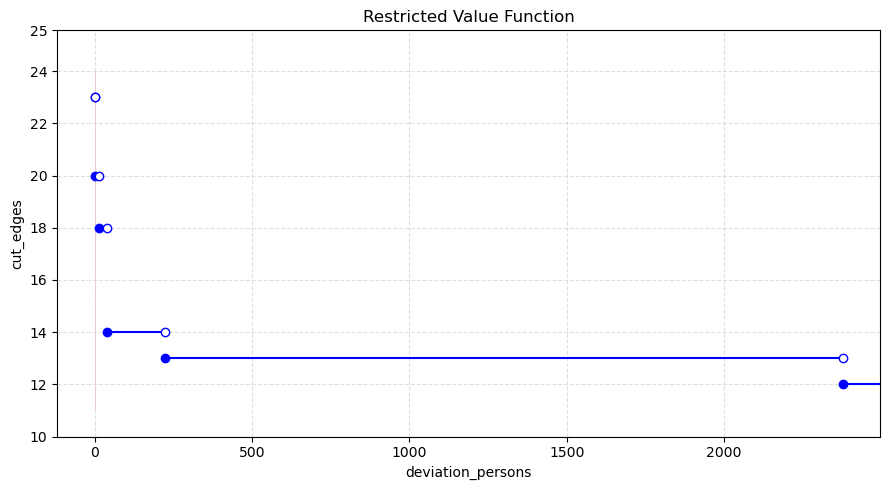

In [10]:
from pareto import ParetoFrontier

print(f"\n{'#' * 100}\nPareto Frontier for state {state},  objective {obj_type}\n{'#' * 100}\n")
pareto = ParetoFrontier(senses, obj_names, state=state, level='county')

if not  plans:
    print("No plan found!")
else:
    for plan, obj_bound, dev in result:
        upper_bound = [dev,  1/obj_bound[0] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[0]]
        lower_bound = [dev,  1/obj_bound[1] if  obj_type == 'bottleneck_Polsby_Popper' else obj_bound[1]]
        
        pareto.add_plan(plan, upper_bound, lower_bound)
            
print("Pareto front plans:", pareto.plans)
print("Pareto front upper bounds:", pareto.upper_bounds)
print("Pareto front lower bounds:", pareto.lower_bounds)
    
#extra_points: list of tuples, each containing (deviation, objective_value, label)
if  year == 2010:
    
    #2010 enacted map scores
    enacted_map_deviation = 3197.333333333372
    enacted_map_scores = {'inverse_Polsby_Popper': 7.75, 'cut_edges': 34.00, 
                                      'perimeter': 42.12, 'average_Polsby_Popper': 0.14,'bottleneck_Polsby_Popper': 0.10}
    # Cooper plan 1
    Cooper_plan_1_deviation = 323.66666666662786
    Cooper_plan_1_scores = {'inverse_Polsby_Popper': 7.31, 'cut_edges': 34.00, 
                                      'perimeter': 40.53, 'average_Polsby_Popper': 0.17,'bottleneck_Polsby_Popper': 0.10}
    # Cooper plan 2
    Cooper_plan_2_deviation = 232.66666666662786
    Cooper_plan_2_scores = {'inverse_Polsby_Popper': 8.18, 'cut_edges': 36.00, 
                                      'perimeter': 43.36, 'average_Polsby_Popper': 0.16,'bottleneck_Polsby_Popper': 0.09}
    # Cooper plan 3
    Cooper_plan_3_deviation = 115.66666666662786
    Cooper_plan_3_scores = {'inverse_Polsby_Popper': 7.25, 'cut_edges': 35.00, 
                                      'perimeter': 40.65, 'average_Polsby_Popper': 0.16,'bottleneck_Polsby_Popper': 0.09}
    extra_points = [
                (enacted_map_deviation,  enacted_map_scores[obj_type], 'Enacted Map'),
                (Cooper_plan_1_deviation,  Cooper_plan_1_scores[obj_type] , 'Cooper plan 1'),
                (Cooper_plan_2_deviation,  Cooper_plan_2_scores[obj_type], 'Cooper plan 2'),
                (Cooper_plan_3_deviation, Cooper_plan_3_scores[obj_type], 'Cooper plan 3'),
                        ]
    
    #extra_colors: list of colors corresponding to the points in extra_points
    extra_colors = ['r', 'g', 'c', 'y']  # Red, Green, Cyan, Yellow for each of the extra points
    
    for ep in extra_points:
        print(f"The {ep[2]} has an objective value of {ep[1]} and a deviation of {ep[0]}.")
else:
    extra_points = None
    extra_colors = None
        
pareto.tighten_lower_bounds()
    
if infeasible_region[1] > 0.5:
    max_dev = max(upper_bound[0] for upper_bound in pareto.upper_bounds)
    max_ce = max(upper_bound[1] for upper_bound in pareto.upper_bounds)
    o1lim=[-1, max_dev+100]
    o2lim=[-2, max_ce*(1.1)]
else:
    o1lim = None
    o2lim = None

pareto.plot_with_custom_x_ranges(method = 'epsilon_constraint_method', splits=None, 
                                 o1lim=o1lim, o2lim=o2lim, infeasible_region = infeasible_region,
                                 extra_points=extra_points, extra_colors=extra_colors)    

In [11]:
from draw import *

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: round(x, 0)}

for plan, obj_bound, dev in result:
    ub = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[0])
    lb = format_obj.get(obj_type, lambda x: round(x, 4))(obj_bound[1])
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    if ub != lb:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), obj_bounds [{ub}, {lb}] {obj_type}"
    else:
        title = f"{round(dev, 2)}-person deviation ({deviation_percentage}%), with {ub} {obj_type}"

    draw_plan(filepath, filename2, G, plan, title=title, year=year)


####################################################################################################
Pareto maps for state WV, objective cut_edges
####################################################################################################



NameError: name 'filepath' is not defined